In [1]:
cd ..

c:\Users\jeong\Desktop\python-practices\reid-practice


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms

import reid.datasets.paired
import reid.losses
import reid.models
import reid.utilities

In [3]:
# Get Device
device = reid.utilities.device()
reid.utilities.manual_seed(777)

In [4]:
# Prepare Datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_inv = torchvision.transforms.Compose([
    torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2)),
])

dataset_faces = torchvision.datasets.ImageFolder('./data/atnt-faces/train',
                                                 transform=transform)
dataset_train = reid.datasets.paired.TriplePairedVisionDataset(
    dataset_faces)
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=256,
                                               shuffle=True,
                                               num_workers=0)

In [5]:
# Create Model
model = reid.models.resnet18_custom(True)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model.to(device)
criterion = torch.nn.TripletMarginLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [6]:
# Train
losses = []
num_epochs = 25
for epoch in range(num_epochs):
    running_loss = 0.0
    lr_sche.step()
    for i, batch in enumerate(dataloader_train, 0):
        inputs_anchor, inputs_positive, inputs_negative = batch
        inputs_anchor = inputs_anchor.to(device)
        inputs_positive = inputs_positive.to(device)
        inputs_negative = inputs_negative.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs_anchor = model(inputs_anchor)
        outputs_positive = model(inputs_positive)
        outputs_negative = model(inputs_negative)
        loss: torch.Tensor = criterion(outputs_anchor, outputs_positive,
                                       outputs_negative)
        loss.backward()
        optimizer.step()

        # print statistics

    print(f'epoch: {epoch}, loss: {loss}')
    losses.append(loss)

    if epoch % 10 == 9:
        torch.save(model.state_dict(), "./triplet_epoch_{}.pth".format(epoch))

epoch: 0, loss: 8.931350708007812
epoch: 1, loss: 1.6352955102920532
epoch: 2, loss: 1.7426694631576538
epoch: 3, loss: 2.48563551902771
epoch: 4, loss: 0.4825425148010254
epoch: 5, loss: 1.3046947717666626
epoch: 6, loss: 1.1938285827636719
epoch: 7, loss: 1.71786367893219
epoch: 8, loss: 0.41589677333831787
epoch: 9, loss: 1.7065494060516357
epoch: 10, loss: 0.1104218140244484
epoch: 11, loss: 0.9750297665596008
epoch: 12, loss: 1.4524176120758057
epoch: 13, loss: 0.2427157312631607
epoch: 14, loss: 0.20502778887748718
epoch: 15, loss: 0.6744273900985718
epoch: 16, loss: 0.4403563439846039
epoch: 17, loss: 0.3948213458061218
epoch: 18, loss: 0.09375455975532532
epoch: 19, loss: 0.5814232230186462
epoch: 20, loss: 0.037283871322870255
epoch: 21, loss: 0.2761923372745514
epoch: 22, loss: 0.3357735276222229
epoch: 23, loss: 0.11935843527317047
epoch: 24, loss: 0.07355216145515442


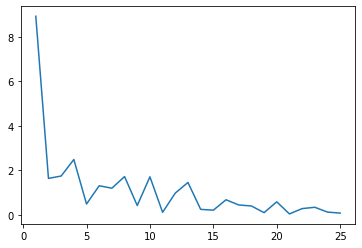

In [7]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), losses)
plt.show()

In [8]:
# Test
def visualize_batch(model, batch, transform, device):
    anchors, others, labels = batch
    anchors, positives, negatives = batch

    for i in range(len(anchors)):
        anchor = anchors[i].unsqueeze(dim=0).to(device)
        positive = positives[i].unsqueeze(dim=0).to(device)
        negative = negatives[i].unsqueeze(dim=0).to(device)

        # calc distance between anchor and X
        output_anchor = model(anchor)
        output_positive = model(positive)
        output_negative = model(negative)
        distance_positive = torch.nn.functional.pairwise_distance(
            output_anchor, output_positive)
        distance_negative = torch.nn.functional.pairwise_distance(
            output_anchor, output_negative)

        # make grid
        imgs = torch.cat(
            (transform(anchor), transform(positive), transform(negative)), 0)
        plt.imshow(torchvision.utils.make_grid(imgs).cpu().permute(1, 2, 0))
        plt.text(75,
                 8,
                 'p: {:.2f}, n: {:.2f}'.format(distance_positive.item(),
                                               distance_negative.item()),
                 fontweight='bold',
                 bbox={
                     'facecolor': 'white',
                     'alpha': 0.8,
                     'pad': 10
                 })
        plt.show()

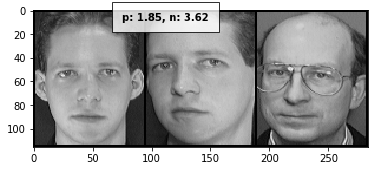

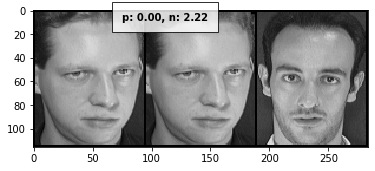

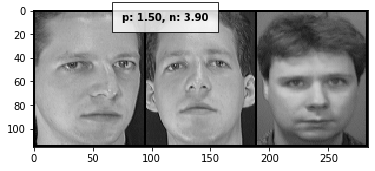

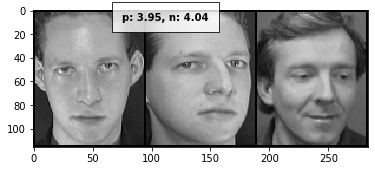

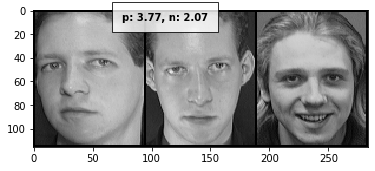

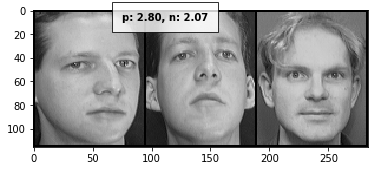

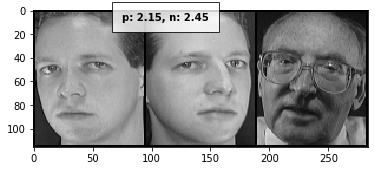

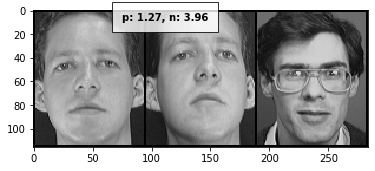

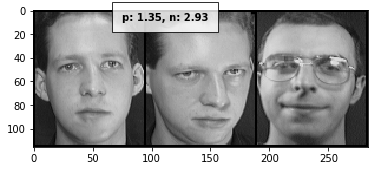

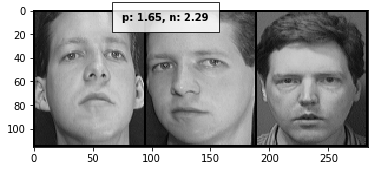

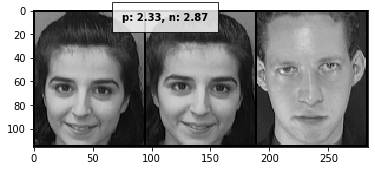

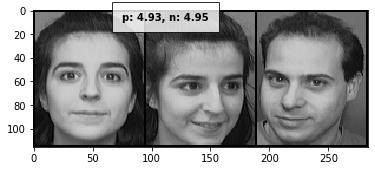

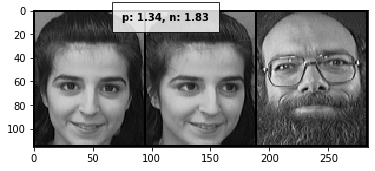

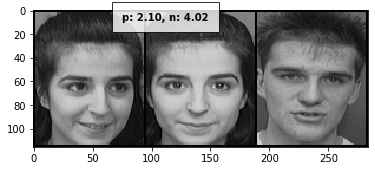

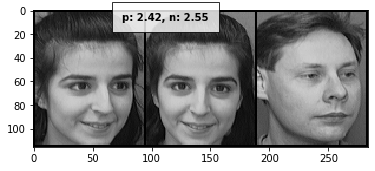

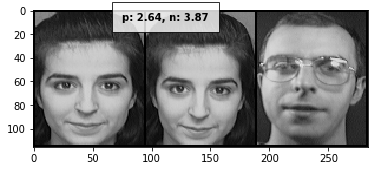

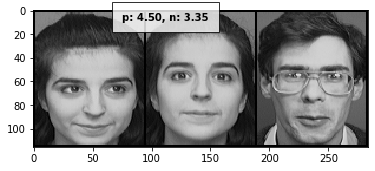

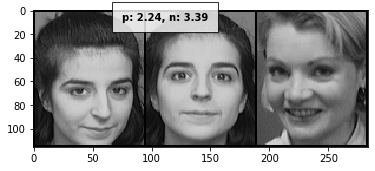

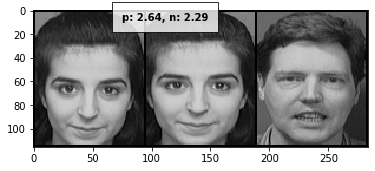

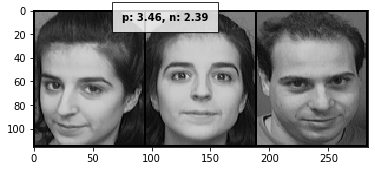

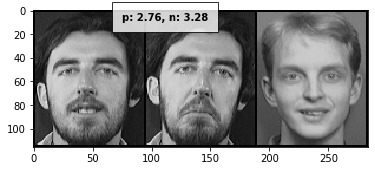

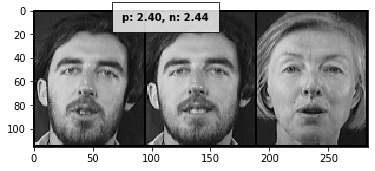

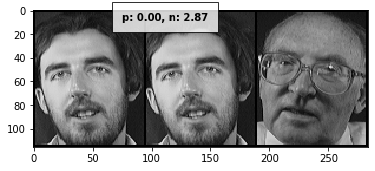

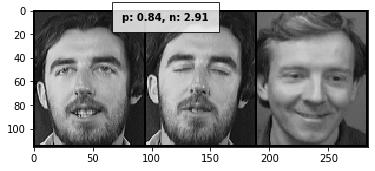

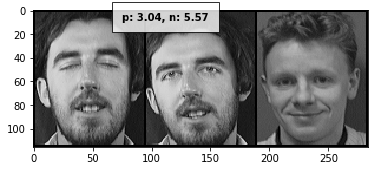

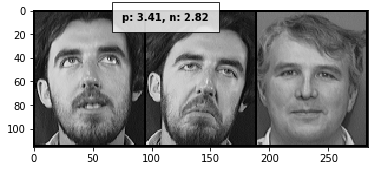

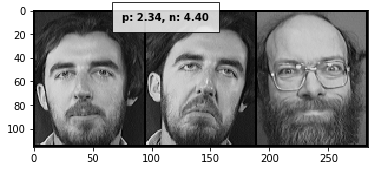

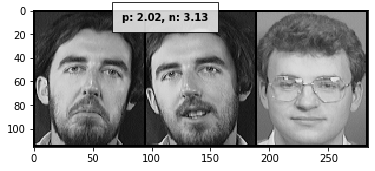

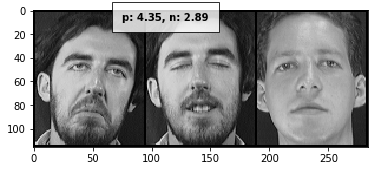

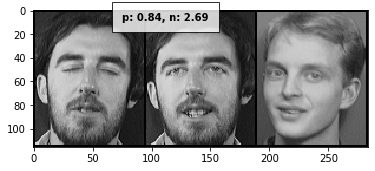

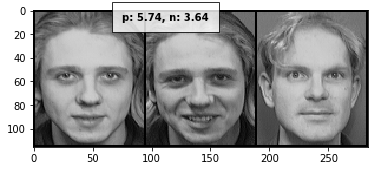

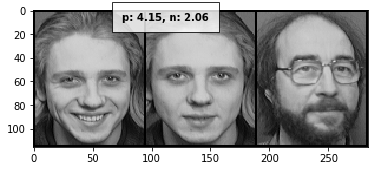

In [9]:
dataloader_test = torch.utils.data.DataLoader(dataset_train,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=0)
batch = next(iter(dataloader_test))
visualize_batch(model, batch, transform_inv, device)